<a href="https://colab.research.google.com/github/kriskalb/CelebA_CV_classification/blob/main/project_celebA_CV_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, BatchNormalization, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD

import os
import zipfile
plt.style.use('ggplot')

%matplotlib inline

# Import oraz wypakowanie danych- colab google

In [3]:
from google.colab import drive


drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/Kurs/projekt_CV/celeba_smaller.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
base_dir = '/tmp/celeba_smaller'
# sciezki
train_dir = os.path.join(base_dir, 'img_align_celeba_smaller/train')
validation_dir = os.path.join(base_dir, 'img_align_celeba_smaller/validation')

# Predykcja atrakcyjności na podstawie zbioru zdjęć gwiazd CelebA

## Wstępne przygotowanie etykiet oraz augmentacja i przygotowanie zdjęć do modelu za pomocą ImageDataGenerator

In [5]:
labels_train= pd.read_csv('/tmp/celeba_smaller/list_attr_celeba_smaller_train.csv')
labels_train.replace(-1, 0, inplace=True)
labels_validation= pd.read_csv('/tmp/celeba_smaller/list_attr_celeba_smaller_validation.csv')
labels_validation.replace(-1, 0, inplace=True)

### Rozkład etykiet train i validation

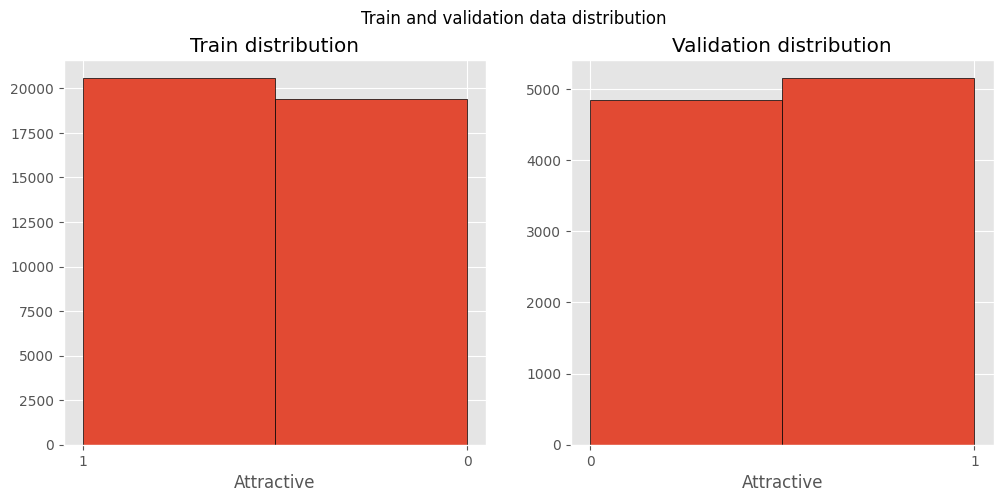

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(labels_train['Attractive'], bins=2, edgecolor='k')
axes[0].set_xlabel('Attractive')
axes[0].set_title('Train distribution')

axes[1].hist(labels_validation['Attractive'], bins=2, edgecolor='k')
axes[1].set_xlabel('Attractive')
axes[1].set_title('Validation distribution')

plt.suptitle('Train and validation data distribution')
plt.show()

In [6]:
labels_train['Attractive'] = labels_train['Attractive'].astype(str)
labels_validation['Attractive'] = labels_validation['Attractive'].astype(str)

In [21]:
# rozmiar zdjęć oraz dataset
IMG_WIDTH = 178
IMG_HEIGHT = 218

train_size = 40000
val_size = 10000

In [22]:
train_datagen  = ImageDataGenerator(rescale = 1/255,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.1,
                                    horizontal_flip=True)
val_datagen  = ImageDataGenerator(rescale = 1/255)

In [23]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_train,
    directory=train_dir,  # Ścieżka do katalogu z obrazami
    x_col="image_id",  # Kolumna z nazwami plików
    y_col="Attractive",  # Kolumna z etykietami binarnymi
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=64,  # Rozmiar batcha
    class_mode="binary",  # Tryb pracy z etykietami, np. 'binary', 'categorical', 'sparse'

)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=labels_validation,
    directory=validation_dir,
    x_col="image_id",  # Kolumna z nazwami plików
    y_col="Attractive",  # Kolumna z etykietami binarnymi
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=64,
    class_mode="binary",

)

Found 40000 validated image filenames belonging to 2 classes.
Found 10000 validated image filenames belonging to 2 classes.


## Transfer learning - model InceptionV3

In [24]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_size // 64,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=val_size // 64
)

Epoch 1/5
625/625 [==============================] - 251s 394ms/step - loss: 0.5412 - accuracy: 0.7504 - val_loss: 0.4732 - val_accuracy: 0.7750
Epoch 2/5
625/625 [==============================] - 218s 348ms/step - loss: 0.4851 - accuracy: 0.7617 - val_loss: 0.4730 - val_accuracy: 0.7704
Epoch 3/5
625/625 [==============================] - 220s 352ms/step - loss: 0.4778 - accuracy: 0.7712 - val_loss: 0.4617 - val_accuracy: 0.7861
Epoch 4/5
625/625 [==============================] - 241s 386ms/step - loss: 0.4780 - accuracy: 0.7713 - val_loss: 0.4605 - val_accuracy: 0.7853
Epoch 5/5
625/625 [==============================] - 238s 380ms/step - loss: 0.4706 - accuracy: 0.7749 - val_loss: 0.4857 - val_accuracy: 0.7620


## Learning curve

In [27]:
def plot_history(history):
  plt.figure(figsize=(8,6))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend('Train loss', 'Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.figure(figsize=(8,6))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend('Train accuracy', 'Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('accuracy')

<ipython-input-27-8d74e04bbdf4>:5: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Train loss', 'Validation loss')
<ipython-input-27-8d74e04bbdf4>:11: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Train accuracy', 'Validation accuracy')


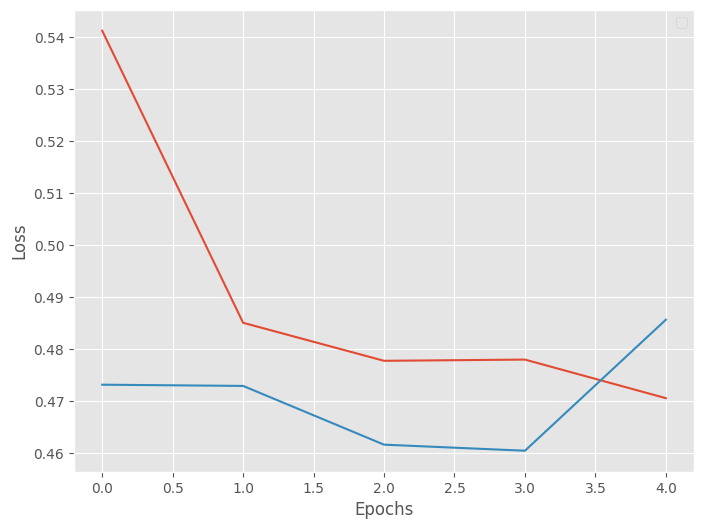

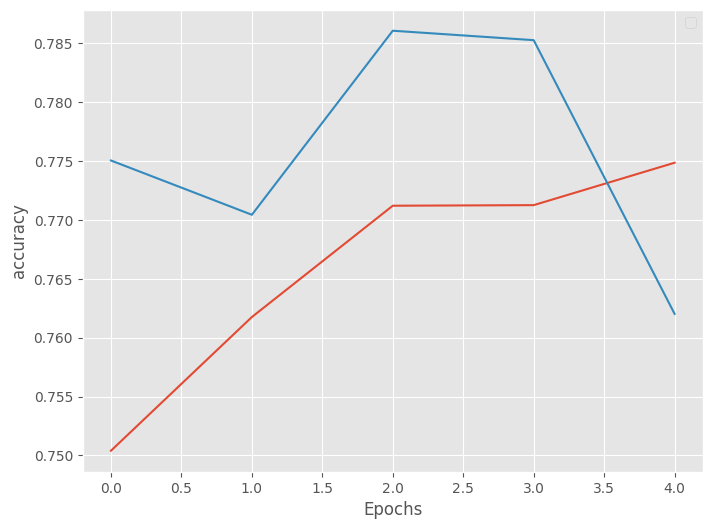

In [28]:
plot_history(history)

# Predykcja atrakcyjności na podstawie datasetu

In [31]:
df = pd.read_csv('/tmp/celeba_smaller/list_attr_celeba_smaller.csv')

In [32]:
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [33]:
df.replace(-1, 0, inplace=True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   image_id             50000 non-null  object
 1   5_o_Clock_Shadow     50000 non-null  int64 
 2   Arched_Eyebrows      50000 non-null  int64 
 3   Attractive           50000 non-null  int64 
 4   Bags_Under_Eyes      50000 non-null  int64 
 5   Bald                 50000 non-null  int64 
 6   Bangs                50000 non-null  int64 
 7   Big_Lips             50000 non-null  int64 
 8   Big_Nose             50000 non-null  int64 
 9   Black_Hair           50000 non-null  int64 
 10  Blond_Hair           50000 non-null  int64 
 11  Blurry               50000 non-null  int64 
 12  Brown_Hair           50000 non-null  int64 
 13  Bushy_Eyebrows       50000 non-null  int64 
 14  Chubby               50000 non-null  int64 
 15  Double_Chin          50000 non-null  int64 
 16  Eyeg

<ipython-input-44-0e4170b849d1>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


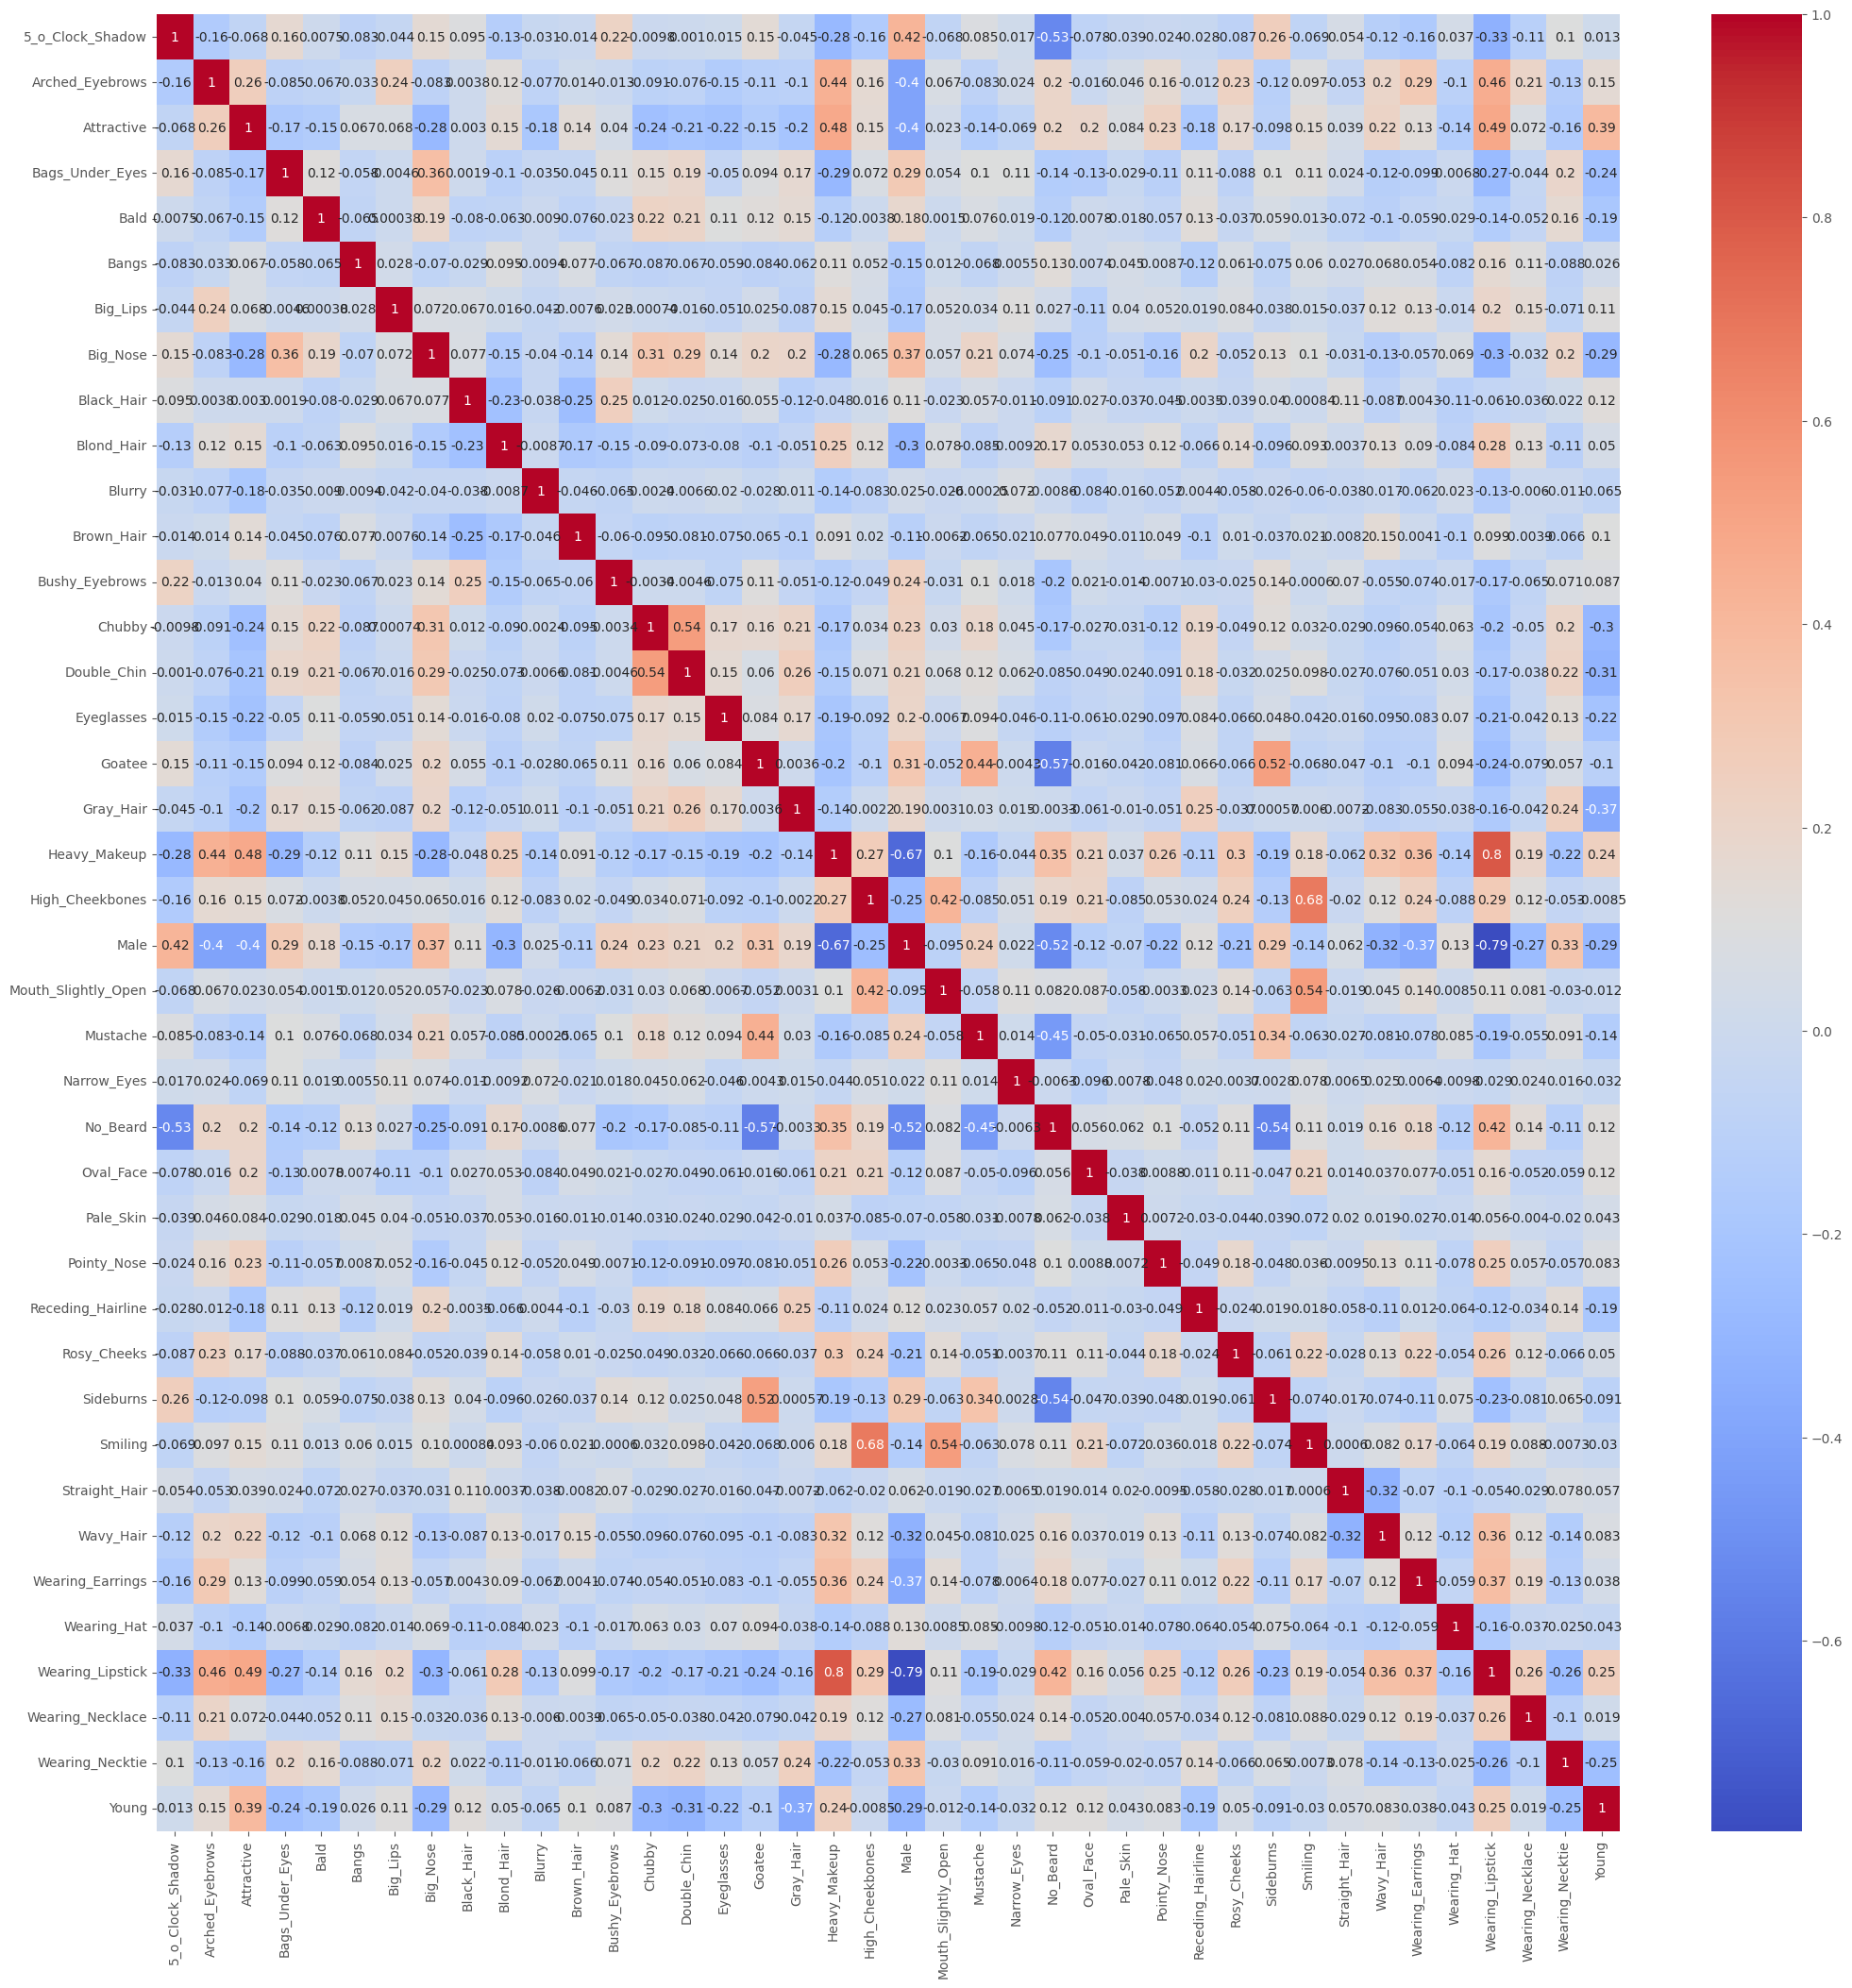

In [44]:
correlation = df.corr()
plt.figure(figsize = (25,25))
color_palette = 'coolwarm'
sns.heatmap(correlation, annot = True,cmap=color_palette)
plt.show()

In [57]:
corr_attractive = df.corr()['Attractive']
corr_attractive[abs(corr_attractive)>0.15]

<ipython-input-57-4cf86bf768fb>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_attractive = df.corr()['Attractive']


Arched_Eyebrows      0.257614
Attractive           1.000000
Bags_Under_Eyes     -0.172331
Big_Nose            -0.283619
Blond_Hair           0.151619
Blurry              -0.182621
Chubby              -0.238606
Double_Chin         -0.207590
Eyeglasses          -0.223918
Goatee              -0.151740
Gray_Hair           -0.201405
Heavy_Makeup         0.482410
Male                -0.404267
No_Beard             0.203946
Oval_Face            0.195722
Pointy_Nose          0.225880
Receding_Hairline   -0.175031
Rosy_Cheeks          0.166376
Wavy_Hair            0.217719
Wearing_Lipstick     0.487563
Wearing_Necktie     -0.156108
Young                0.387385
Name: Attractive, dtype: float64

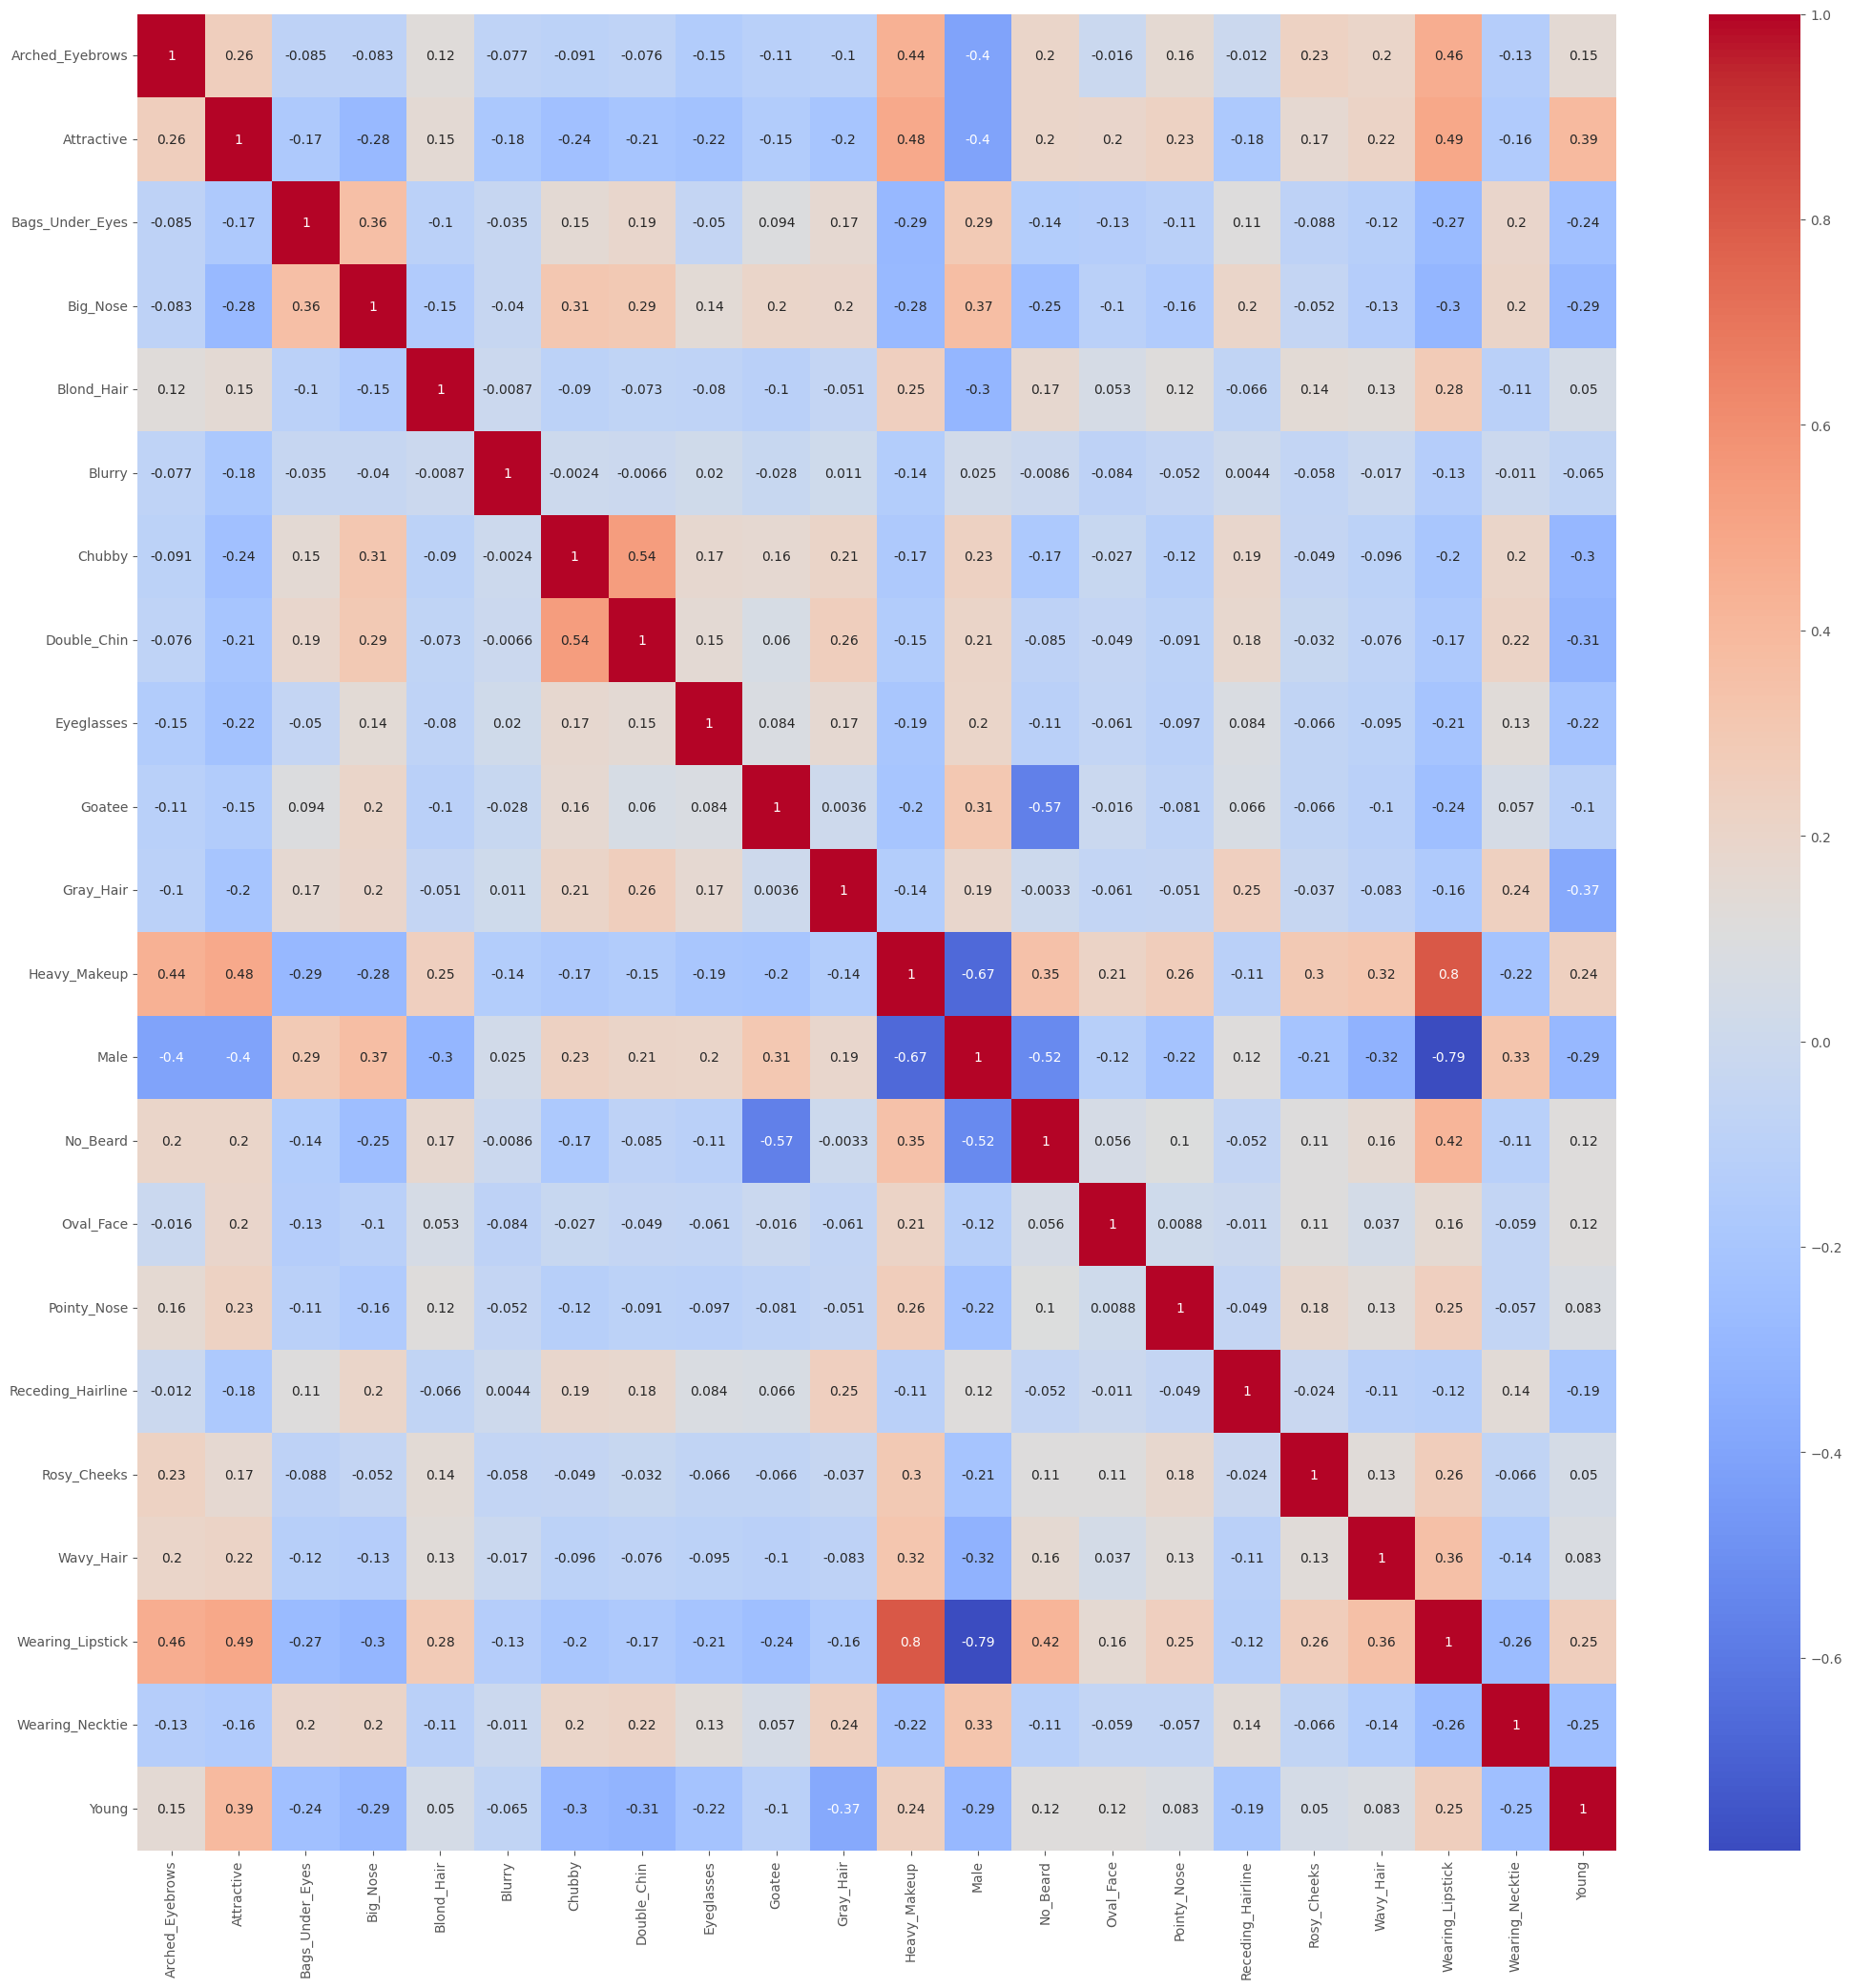

In [59]:
labels_x = list(correlation[abs(correlation['Attractive'])>0.15]['Attractive'].index)
plt.figure(figsize = (25,25))
color_palette = 'coolwarm'
sns.heatmap(df[labels_x].corr(), annot = True,cmap=color_palette)
plt.show()

In [37]:
X = df.drop('Attractive', axis=1)
y = df['Attractive']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)